<a href="https://www.kaggle.com/hamedetezadi/nyc-taxi-fare-pred?scriptVersionId=88415603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
# Library
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('fivethirtyeight');
plt.rcParams['font.size'] = 12;
plt.figure(figsize=(14,7));
palette = sns.color_palette('Paired', 10);

# map
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime



<Figure size 1008x504 with 0 Axes>

In [3]:
#Reading File and see the data
df = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows=1000000)
df.shape
df.head()



,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [5]:
'''
The points we should notice:
    1)The null should be removed
    2)The duplicates should be removed
    3)The number of passangers is important 
    4)The distance is important
    5)The season is important
    6)The month is important
    7)The date is important
    8)The hour is important
    9)The location of pick up is important
    10)The location of drop off is important
    11)Unusable columns should be removed
    12)Fare amount should not be negative or zero
    13)Removing outliers in fare column
    14)The No. of passengers should not be more than 4 and should not be zero
    15)The distance should not be 0 or more than 783 in NYC
    16) Min fare is 2.5$  https://www.introducingnewyork.com/taxis
    17)Peak hour supplement,night suplement,cuty tax and an hour's wait money can be considered
   
'''


"\nThe points we should notice:\n    1)The null should be removed\n    2)The duplicates should be removed\n    3)The number of passangers is important \n    4)The distance is important\n    5)The season is important\n    6)The month is important\n    7)The date is important\n    8)The hour is important\n    9)The location of pick up is important\n    10)The location of drop off is important\n    11)Unusable columns should be removed\n    12)Fare amount should not be negative or zero\n    13)Removing outliers in fare column\n    14)The No. of passengers should not be more than 4 and should not be zero\n    15)The distance should not be 0 or more than 783 in NYC\n    16) Min fare is 2.5$  https://www.introducingnewyork.com/taxis\n    17)Peak hour supplement,night suplement,cuty tax and an hour's wait money can be considered\n   \n"

In [6]:
100 * df.isnull().sum().sort_values(ascending=False)/len(df) #df.isnull().sum() 

dropoff_longitude    0.001
dropoff_latitude     0.001
key                  0.000
fare_amount          0.000
pickup_datetime      0.000
pickup_longitude     0.000
pickup_latitude      0.000
passenger_count      0.000
dtype: float64

In [7]:
#Removing useless columns
df.drop('key',axis=1, inplace=True)

In [8]:
#Removing Nulls
df.dropna(inplace=True)
df.isnull().sum() 

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
#Removing Duplicates
size_before_Removing = len(df)
df = df.drop_duplicates()
size_after_Removing = len(df)
print(str(size_before_Removing - size_after_Removing) + " duplicates were removed.")

0 duplicates were removed.


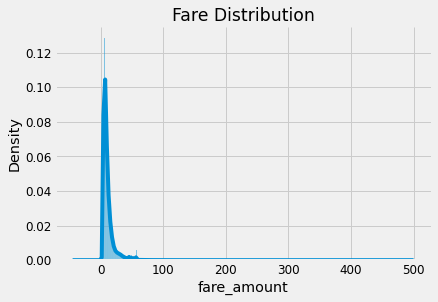

In [10]:
def plot_dist(series=df["fare_amount"], title="Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

In [11]:
#deleting  longitude or latitude equal to 0
drop_i = df[(df.pickup_longitude == 0) | (df.pickup_latitude == 0) | (df.dropoff_longitude == 0) | (df.dropoff_latitude == 0)].index
df = df.drop(drop_i)

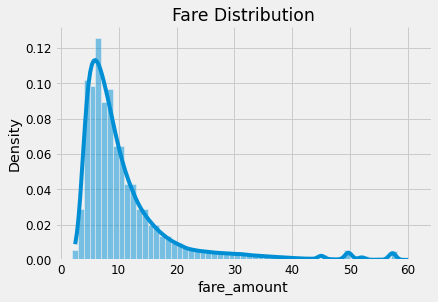

In [12]:
df = df[df.fare_amount.between(2.5, 60)]
plot_dist(df.fare_amount)

In [13]:
#deleting rows with fare price less or equal to 2.5$   #Minimum fare: US$ 2.50.
drop_i = df[df.fare_amount <= 2.5].index
df = df.drop(drop_i)

In [14]:
'''
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(2, 60, 5)), include_lowest=True).astype('str')

# Uppermost bin
df['fare-bin'] = df['fare-bin'].replace(np.nan, '[45+]')

# apply this to clean up the first bin's label
df['fare-bin'] = df['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
df = df.sort_values(by='fare_amount')

sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.show()
'''

'\ndf[\'fare-bin\'] = pd.cut(df[\'fare_amount\'], bins = list(range(2, 60, 5)), include_lowest=True).astype(\'str\')\n\n# Uppermost bin\ndf[\'fare-bin\'] = df[\'fare-bin\'].replace(np.nan, \'[45+]\')\n\n# apply this to clean up the first bin\'s label\ndf[\'fare-bin\'] = df[\'fare-bin\'].apply(lambda x: x.replace(\'-0.001\', \'0\'))\n\n# sort by fare the correct look in the chart\ndf = df.sort_values(by=\'fare_amount\')\n\nsns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);\nsns.despine()\nplt.show()\n'

In [15]:
#print(round(df['fare_amount'].mean() + 5* df['fare_amount'].std(),2))

In [16]:
#Neglecting outliers: 5*standard deviation
df[df.fare_amount > round(df['fare_amount'].mean() + 5* df['fare_amount'].std(),2)]




,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
35,58.00,2015-01-11 03:15:38 UTC,-73.983330,40.738720,-73.933197,40.847225,1
286,57.33,2013-06-14 17:37:00 UTC,-73.781127,40.645007,-73.981802,40.762515,1
437,57.33,2014-05-12 23:31:00 UTC,-73.790250,40.643705,-74.002270,40.734542,1
449,56.80,2012-12-21 13:10:00 UTC,-73.978817,40.761517,-73.789255,40.642677,1
622,57.33,2014-11-18 09:19:00 UTC,-73.776720,40.645412,-73.978832,40.774932,1
...,...,...,...,...,...,...,...
998928,57.33,2014-09-11 18:34:08 UTC,-73.929542,40.799794,-73.790778,40.644330,2
999165,57.54,2015-05-08 17:47:00 UTC,-73.993935,40.724747,-73.781487,40.648003,1
999282,57.33,2013-05-21 19:27:00 UTC,40.738612,-73.983365,40.644720,-73.792798,5
999302,57.33,2013-10-21 15:34:41 UTC,-73.783170,40.644143,-73.980042,40.764223,3


In [17]:
drop_i = df[df.fare_amount > round(df['fare_amount'].mean() + 5* df['fare_amount'].std(),2)].index
df = df.drop(drop_i)

In [18]:
df.passenger_count.describe()
drop_i = df[(df.passenger_count == 0) | (df.passenger_count > 5)].index
df = df.drop(drop_i)

#The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab 
#or five (5) passengers in a five (5) passenger taxicab, 
#except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.

In [19]:
#Find boudaries from test set and remove outliers from training set
data_test = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/test.csv")
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = data_test[col].min()
    MAX = data_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [20]:
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -74.3, right = -72.9 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72.9 )]

center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)


heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [21]:
#HAVERSINE FORMULA
def haversine_distance(pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude):
    dlon = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    dlat = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    pre_dist = np.sin(dlat / 2)**2 + np.cos(pickup_latitude) * np.cos(dropoff_latitude) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(pre_dist), np.sqrt(1 - pre_dist))
    distance = 6373.0 * c
    return distance

In [22]:
df['distance'] = df.apply(lambda x: haversine_distance(x.pickup_longitude,x.pickup_latitude,x.dropoff_longitude,x.dropoff_latitude),axis=1) 



In [23]:
#Removing negative distances!
df.head(3)
df['distance'] = np.int32(df['distance'])
df = df.drop(df[df.distance < 0].index)
#Removing none related distance
df = df.drop(df[df.distance > 783].index)    #783 m^2 area of NYC

In [24]:
#new features from timedate
def time_features(df,time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['day'] = pd.to_datetime(df[time_col]).dt.day
    df['dayofweek'] = pd.to_datetime(df[time_col]).dt.dayofweek
    df['week']=pd.to_datetime(df[time_col]).dt.isocalendar().week
    df['hour'] = pd.to_datetime(df[time_col]).dt.hour
    df['minute'] = pd.to_datetime(df[time_col]).dt.minute
    df['month'] = pd.to_datetime(df[time_col]).dt.month
    return df

In [25]:
df = time_features(df,'pickup_datetime')
df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,dayofweek,week,hour,minute,month
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1,15,0,25,17,26,6
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8,5,1,1,16,52,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1,18,3,33,0,35,8
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2,21,5,16,4,30,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2,9,1,10,7,51,3


In [26]:
heatmap_data_by_hour = []
__df__ = df.head(10000)
for hour in df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['pickup_latitude', 'pickup_longitude']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [27]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

In [28]:
#creating bins for minute

def min_bin(min):
    if min >= 46: return 3
    elif min >= 31: return 2
    elif min >= 16: return 1
    elif min >= 0: return 0

In [29]:
df['min_bin'] = df.minute.apply(lambda x:min_bin(x))
df.head(5)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,dayofweek,week,hour,minute,month,min_bin
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1,15,0,25,17,26,6,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8,5,1,1,16,52,1,3
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1,18,3,33,0,35,8,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2,21,5,16,4,30,4,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2,9,1,10,7,51,3,3


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818354 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        818354 non-null  float64            
 1   pickup_datetime    818354 non-null  datetime64[ns, UTC]
 2   pickup_longitude   818354 non-null  float64            
 3   pickup_latitude    818354 non-null  float64            
 4   dropoff_longitude  818354 non-null  float64            
 5   dropoff_latitude   818354 non-null  float64            
 6   passenger_count    818354 non-null  int64              
 7   distance           818354 non-null  int32              
 8   day                818354 non-null  int64              
 9   dayofweek          818354 non-null  int64              
 10  week               818354 non-null  UInt32             
 11  hour               818354 non-null  int64              
 12  minute             818354 non-

In [31]:
df.month = np.int32(df.month)

In [32]:
df.month.value_counts().sort_index()

1     73584
2     69446
3     76576
4     75322
5     76312
6     73315
7     62138
8     58201
9     61768
10    66203
11    62232
12    63257
Name: month, dtype: int64

In [33]:
tp = df.groupby('month').sum().sort_values('fare_amount',ascending=False)
tp.head(12)
#April, May, June are the highest grossing months(maybe because of tourist)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,dayofweek,week,hour,minute,min_bin
month,,,,,,,,,,,,,
5,847880.85,-5.645072e+06,3.109963e+06,-5.644694e+06,3.110161e+06,121609,246147,1187503,234592,1514909,1027127,2254500,110871
3,815879.42,-5.664682e+06,3.120707e+06,-5.664320e+06,3.120896e+06,121269,234232,1232145,233345,859855,1039522,2264259,111303
4,812741.92,-5.571877e+06,3.069630e+06,-5.571527e+06,3.069813e+06,120022,234259,1175880,226349,1173846,1022265,2222653,109194
6,809154.90,-5.423375e+06,2.987810e+06,-5.423046e+06,2.988004e+06,117108,234435,1131126,218024,1779477,984125,2172191,106976
1,756248.98,-5.443319e+06,2.998803e+06,-5.443018e+06,2.998967e+06,118243,217300,1209672,228346,278585,1000361,2185082,107665
10,733015.08,-4.897313e+06,2.697972e+06,-4.897014e+06,2.698141e+06,104974,208703,1059397,203830,2762574,894312,1956451,96232
2,726593.76,-5.137260e+06,2.830137e+06,-5.136925e+06,2.830318e+06,109660,206741,1031406,212207,488364,944696,2050170,100727
12,700191.99,-4.679368e+06,2.577951e+06,-4.679080e+06,2.578085e+06,102467,195905,956655,190971,3090793,857359,1867998,91858
9,691668.34,-4.569236e+06,2.517203e+06,-4.568924e+06,2.517357e+06,98464,196095,971777,188199,2310321,829456,1820691,89383


In [34]:
tp = df.groupby('hour').sum().sort_values('fare_amount',ascending=False)
tp.head(24)
# peak hours between 6 pm to 22 pm

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,dayofweek,week,minute,month,min_bin
hour,,,,,,,,,,,,,
19,521082.13,-3.788762e+06,2.087283e+06,-3.788650e+06,2.087374e+06,83590,143494,803547,148736,1296392,1503816,319169,73786
18,519454.61,-3.665174e+06,2.019294e+06,-3.665086e+06,2.019385e+06,79953,137704,776014,142669,1241782,1481920,306000,73141
22,499862.16,-3.375821e+06,1.859572e+06,-3.375568e+06,1.859715e+06,75662,154879,717509,135610,1166610,1319976,287368,64535
20,495119.96,-3.508111e+06,1.932566e+06,-3.507977e+06,1.932673e+06,77592,146708,745602,136841,1206498,1383330,297150,67779
21,491702.09,-3.414715e+06,1.881060e+06,-3.414514e+06,1.881183e+06,75922,149344,728436,133793,1178021,1359762,290007,66831
14,464590.96,-3.099376e+06,1.707610e+06,-3.099233e+06,1.707697e+06,66702,123230,654968,124953,1071212,1244442,263574,61314
23,454226.29,-2.973606e+06,1.637959e+06,-2.973336e+06,1.638085e+06,67036,143832,635144,126128,1030734,1143582,253838,55601
15,446652.63,-2.943692e+06,1.621874e+06,-2.943577e+06,1.621967e+06,64193,120668,622012,119417,1007914,1150967,248361,56226
17,443065.88,-3.018108e+06,1.662872e+06,-3.018052e+06,1.662980e+06,65594,119913,636728,119433,1032824,1262054,254308,62742


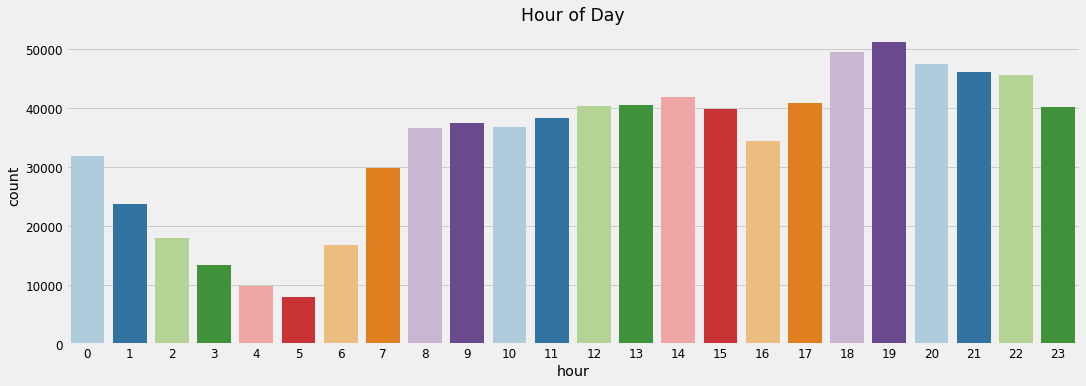

In [35]:
sns.catplot(x="hour", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

In [36]:
tp = df.groupby('dayofweek').sum().sort_values('fare_amount',ascending=False)
tp.head(7)
#friday,saturday and sunday has minimum earning(wed,tue,thu has highest earning)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,week,hour,minute,month,min_bin
dayofweek,,,,,,,,,,,,,
4,1369655.58,-9.289550e+06,5.117702e+06,-9.288963e+06,5.117971e+06,201407,385889,1983231,3178442,1710770,3701920,781662,181901
3,1342621.63,-9.051899e+06,4.986881e+06,-9.051326e+06,4.987150e+06,191595,376426,1915958,3111876,1707947,3623424,765454,178206
5,1306764.43,-9.074858e+06,4.999057e+06,-9.074184e+06,4.999371e+06,206836,383646,1946416,3100774,1596007,3638029,764664,179277
2,1279096.14,-8.795085e+06,4.845406e+06,-8.794568e+06,4.845700e+06,184577,354771,1860598,3040957,1657949,3524391,747613,173345
1,1235025.78,-8.544076e+06,4.707213e+06,-8.543661e+06,4.707475e+06,179073,345635,1799807,2957443,1624185,3421497,727466,168483
6,1198966.80,-7.940036e+06,4.373975e+06,-7.939369e+06,4.374338e+06,178351,373525,1681328,2716637,1281445,3155762,671827,154971
0,1141384.17,-7.841502e+06,4.320160e+06,-7.841152e+06,4.320437e+06,164784,336690,1653346,2719393,1479411,3128364,668408,153839


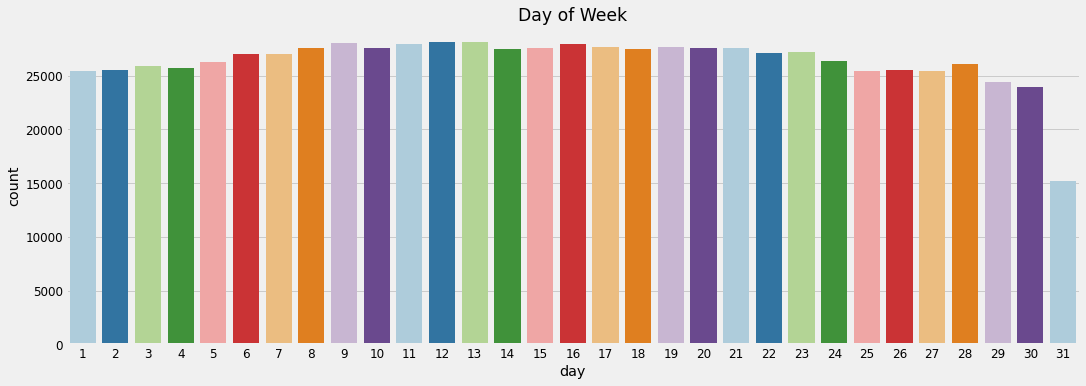

In [37]:
sns.catplot(x="day", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

In [38]:
tp = df.groupby(['pickup_longitude','pickup_latitude']).sum().sort_values('fare_amount',ascending=False)
tp.head(5)
#highest earning and also passenger wise place is "Keith Mitchell Forest, Squantuck Road, Seymour"
#second highest "Maple Court, East 122nd Street"
#https://www.gps-coordinates.net/map/state/NY

,,fare_amount,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,dayofweek,week,hour,minute,month,min_bin
pickup_longitude,pickup_latitude,,,,,,,,,,,,
-73.137393,41.366138,3397.39,-22156.154920,12440.985786,402,9084,4765,807,7989,4443,9080,1949,445
-73.940717,40.803238,357.40,-2513.984378,1387.310092,54,0,503,107,945,504,1099,234,56
-73.937835,40.758457,336.66,-887.026430,488.969790,22,76,216,34,412,144,363,98,16
-73.874500,40.774100,315.50,-813.657000,448.387200,14,115,173,21,336,165,262,82,13
-73.937475,40.758242,245.90,-1700.561925,937.439566,31,0,342,57,587,300,722,147,36


In [39]:
tp = df.groupby(['dropoff_longitude','dropoff_latitude']).sum().sort_values('fare_amount',ascending=False)
tp.head(5)
#dropoff also showing same places



,,fare_amount,pickup_longitude,pickup_latitude,passenger_count,distance,day,dayofweek,week,hour,minute,month,min_bin
dropoff_longitude,dropoff_latitude,,,,,,,,,,,,
-73.137393,41.366138,2375.61,-17645.111598,9955.099037,321,2506,3772,657,6213,3604,7036,1519,346
-73.940717,40.803238,357.40,-2513.984378,1387.310092,54,0,503,107,945,504,1099,234,56
-73.937475,40.758242,245.90,-1700.561925,937.439566,31,0,342,57,587,300,722,147,36
-73.937350,40.758115,240.70,-1256.934950,692.887955,22,0,239,56,406,256,567,103,28
-73.995808,40.761200,239.50,-1701.903584,937.507600,23,0,319,64,527,271,677,134,34


<AxesSubplot:>

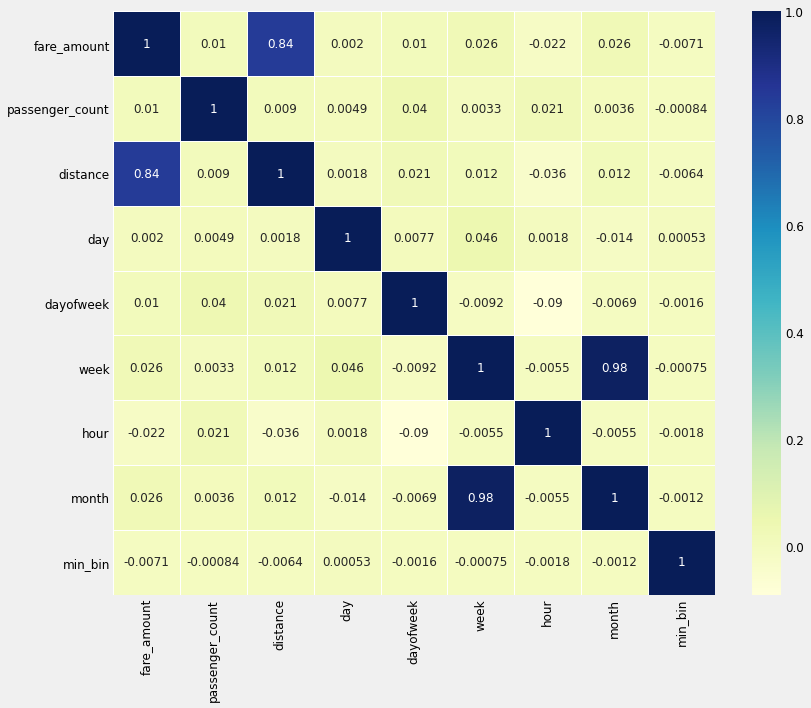

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.heatmap(df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','minute'],axis=1).corr(),cmap='YlGnBu',linewidths=.5,annot=True)

In [41]:
X = df.drop(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','minute'],axis=1)
y = df.fare_amount

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [43]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
y_pred = reg.predict(X_test)
print('Linear regression, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Linear regression, Root mean square is:  4.532673343437886


In [44]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(X_train, y_train)
reg.score(X_train, y_train)
y_pred = reg.predict(X_test)
print('DecisionTreeRegressor, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

DecisionTreeRegressor, Root mean square is:  5.271873802712229


In [45]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor().fit(X_train.values, y_train.values)
gbm.score(X_train.values, y_train.values)
y_pred = gbm.predict(X_test.values)
print('RandomForestRegressor, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

RandomForestRegressor, Root mean square is:  3.6384985060022217


In [46]:
test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')


In [47]:
test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [48]:
test['distance'] = test.apply(lambda x: haversine_distance(x.pickup_longitude,x.pickup_latitude,x.dropoff_longitude,x.dropoff_latitude),axis=1) 
test['distance'] = np.int32(test['distance'])
test = time_features(test,'pickup_datetime')
test['min_bin'] = test.minute.apply(lambda x:min_bin(x))
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
day                  0
dayofweek            0
week                 0
hour                 0
minute               0
month                0
min_bin              0
dtype: int64

In [49]:
pred = test.drop(['key','pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','minute'],axis=1)

In [50]:
fare_amount = gbm.predict(pred.values)

In [51]:
submission = pd.DataFrame()
submission['key'] = test['key']
submission['fare_amount'] = fare_amount

In [52]:
submission.to_csv('submission.csv',index=False)